Tutorial

This tutorial shows the basic steps of using SEP to detect objects in an image and perform some basic aperture photometry.

Here, we use the fitsio package, just to read the test image, but you can also use astropy.io.fits for this purpose (or any other FITS reader).

In [1]:
import numpy as np
import sep

In [2]:
# additional setup for reading the test image and displaying plots
import fitsio
import matplotlib.pyplot as plt
from matplotlib import rcParams

%matplotlib inline

rcParams['figure.figsize'] = [10., 8.]

First, we’ll read an example image from a FITS file and display it, just to show what we’re dealing with. The example image is just 256 x 256 pixels.

In [3]:
# read image into standard 2-d numpy array
data = fitsio.read("../data/hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits")
data = data.astype('float32')

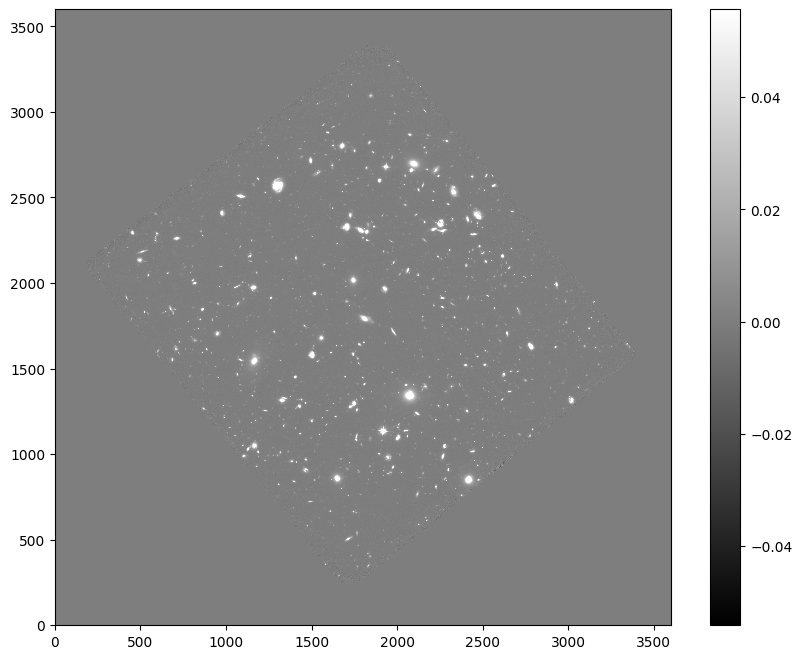

In [4]:
# show the image
m, s = np.mean(data), np.std(data)
plt.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar();
#fig.savefig("image.png", bbox_inches="tight",)

Background subtraction

Most optical/IR data must be background subtracted before sources can be detected. In SEP, background estimation and source detection are two separate steps.

In [5]:
# measure a spatially varying background on the image
bkg = sep.Background(data)

There are various options for controlling the box size used in estimating the background. It is also possible to mask pixels. For example:

bkg = sep.Background(data, mask=mask, bw=64, bh=64, fw=3, fh=3)

See the reference section for descriptions of these parameters.

This returns an Background object that holds information on the spatially varying background and spatially varying background noise level. We can now do various things with this Background object:

In [6]:
# get a "global" mean and noise of the image background:
print(bkg.globalback)
print(bkg.globalrms)

0.0
0.0005398219218477607


In [7]:
# evaluate background as 2-d array, same size as original image
bkg_image = bkg.back()
# bkg_image = np.array(bkg) # equivalent to above

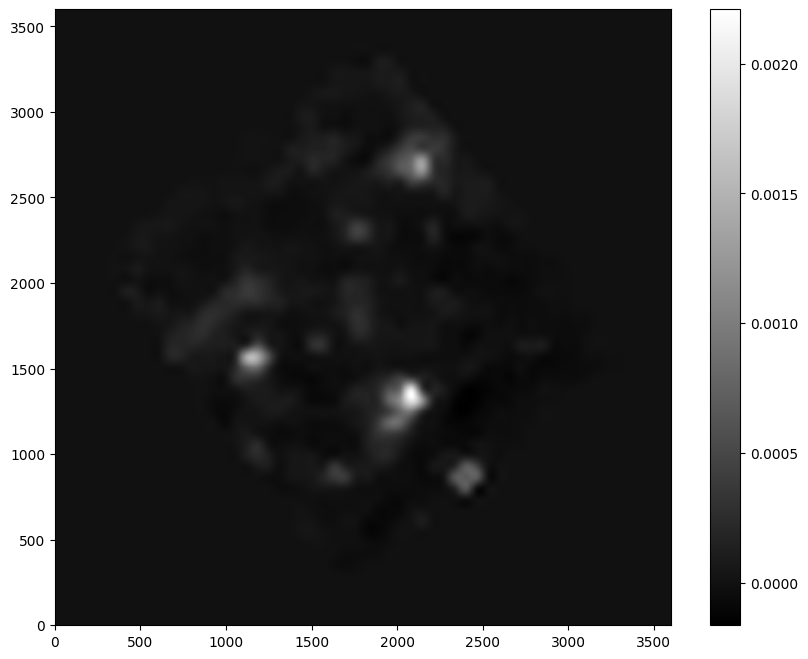

In [8]:
# show the background
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();
#fig.savefig("background.png", bbox_inches="tight",)

In [9]:
# evaluate the background noise as 2-d array, same size as original image
bkg_rms = bkg.rms()

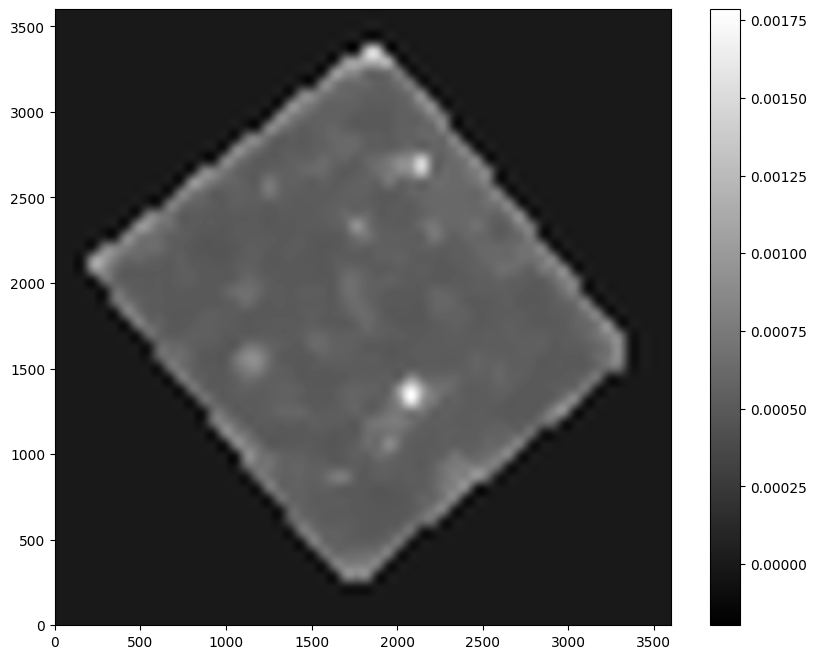

In [10]:
# show the background noise
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();
#fig.savefig("background_noise.png", bbox_inches="tight",)

In [11]:
# subtract the background
data_sub = data - bkg

Object detection

Now that we’ve subtracted the background, we can run object detection on the background-subtracted data. You can see the background noise level is pretty flat. So here we’re setting the detection threshold to be a constant value of 1.5𝜎 where 𝜎 is the global background RMS.

In [12]:
objects = sep.extract(data_sub, 1.5, err=bkg.globalrms)

sep.extract has many options for controlling detection threshold, pixel masking, filtering, and object deblending. See the reference documentation for details.

objects is a NumPy structured array with many fields.

In [13]:
# how many objects were detected
len(objects)

8640

objects['x'] and objects['y'] will give the centroid coordinates of the objects. Just to check where the detected objects are, we’ll over-plot the object coordinates with some basic shape parameters on the image:

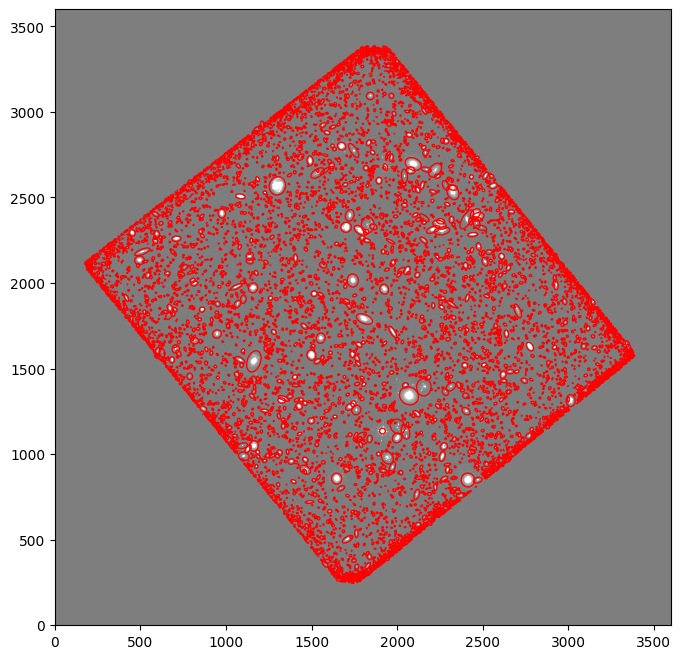

In [14]:
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)
#fig.savefig("objects.png", bbox_inches="tight",)

objects has many other fields, giving information such as second moments, and peak pixel positions and values. See the reference documentation for sep.extract for descriptions of these fields. You can see the available fields:

In [15]:
# available fields
objects.dtype.names

('thresh',
 'npix',
 'tnpix',
 'xmin',
 'xmax',
 'ymin',
 'ymax',
 'x',
 'y',
 'x2',
 'y2',
 'xy',
 'errx2',
 'erry2',
 'errxy',
 'a',
 'b',
 'theta',
 'cxx',
 'cyy',
 'cxy',
 'cflux',
 'flux',
 'cpeak',
 'peak',
 'xcpeak',
 'ycpeak',
 'xpeak',
 'ypeak',
 'flag')

Aperture photometry

Finally, we’ll perform simple circular aperture photometry with a 3 pixel radius at the locations of the objects:

In [16]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'],
                                     3.0, err=bkg.globalrms, gain=1.0)

flux, fluxerr and flag are all 1-d arrays with one entry per object.

In [17]:
# show the first 10 objects results:
for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

object 0: flux = 0.031282 +/- 0.176890
object 1: flux = 0.031018 +/- 0.176142
object 2: flux = -0.024388 +/- 0.002883
object 3: flux = 0.001947 +/- 0.044219
object 4: flux = 0.012457 +/- 0.111649
object 5: flux = -0.011228 +/- 0.002875
object 6: flux = 0.029368 +/- 0.171394
object 7: flux = -0.009126 +/- 0.002875
object 8: flux = 0.048023 +/- 0.219161
object 9: flux = 0.027840 +/- 0.166877


Number of sources:

In [18]:
len(objects)

8640

Histogram of fluxes:

In [19]:
flux, fluxerr, flag = sep.sum_circle(
    data_sub,
    objects['x'],
    objects['y'],
    5.0,
    err=bkg.globalrms,
    gain=1.0
)

In [23]:
len(flux)

8640

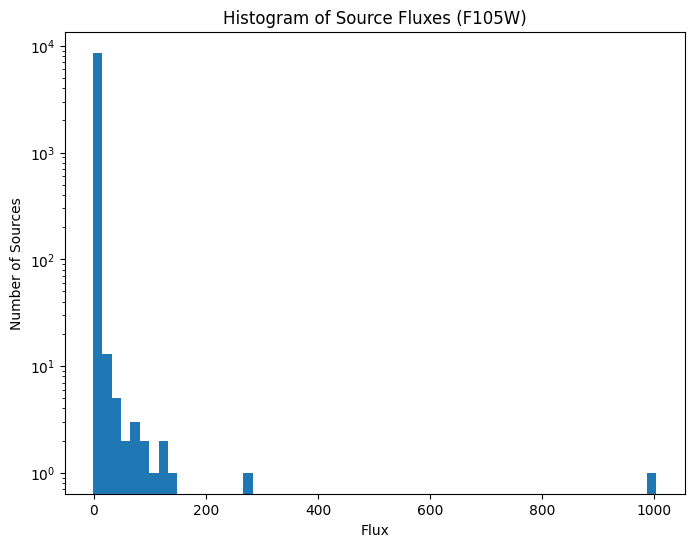

In [26]:
plt.figure(figsize=(8,6))
plt.hist(flux, bins=60)
plt.xlabel("Flux")
plt.ylabel("Number of Sources")
plt.yscale('log') 
plt.title("Histogram of Source Fluxes (F105W)")
plt.show()

Distribution:

In [31]:
mean_flux = np.mean(flux)
median_flux = np.median(flux)
std_flux = np.std(flux)

print("Mean flux:", mean_flux)
print("Median flux:", median_flux)
print("Standard deviation:", std_flux)

Mean flux: 0.5607719971104487
Median flux: 0.04257602631967529
Standard deviation: 11.762500537730492


Largest FLux and Location:

In [32]:
max_flux = np.max(flux)
max_index = np.argmax(flux) 
print("Largest flux:", max_flux)
print("Index of largest flux:", max_index)

Largest flux: 1003.6865444278716
Index of largest flux: 2066


In [33]:
x_max = objects['x'][max_index]
y_max = objects['y'][max_index]

print("Position of largest source: x =", x_max, "y =", y_max)


Position of largest source: x = 1914.2549094866436 y = 1134.3164850725645


In [34]:
sigma_from_mean = (max_flux - mean_flux) / std_flux
print("Number of standard deviations from mean:", sigma_from_mean)


Number of standard deviations from mean: 85.28167707308845


In [41]:
f105w = fitsio.read("../data/hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits").astype(np.float32)
f125w = fitsio.read("../data/hlsp_hudf12_hst_wfc3ir_udfmain_f125w_v1.0_drz.fits").astype(np.float32)
f160w = fitsio.read("../data/hlsp_hudf12_hst_wfc3ir_udfmain_f160w_v1.0_drz.fits").astype(np.float32)

print("F105W shape:", f105w.shape)
print("F125W shape:", f125w.shape)
print("F160W shape:", f160w.shape)

F105W shape: (3600, 3600)
F125W shape: (3600, 3600)
F160W shape: (3600, 3600)


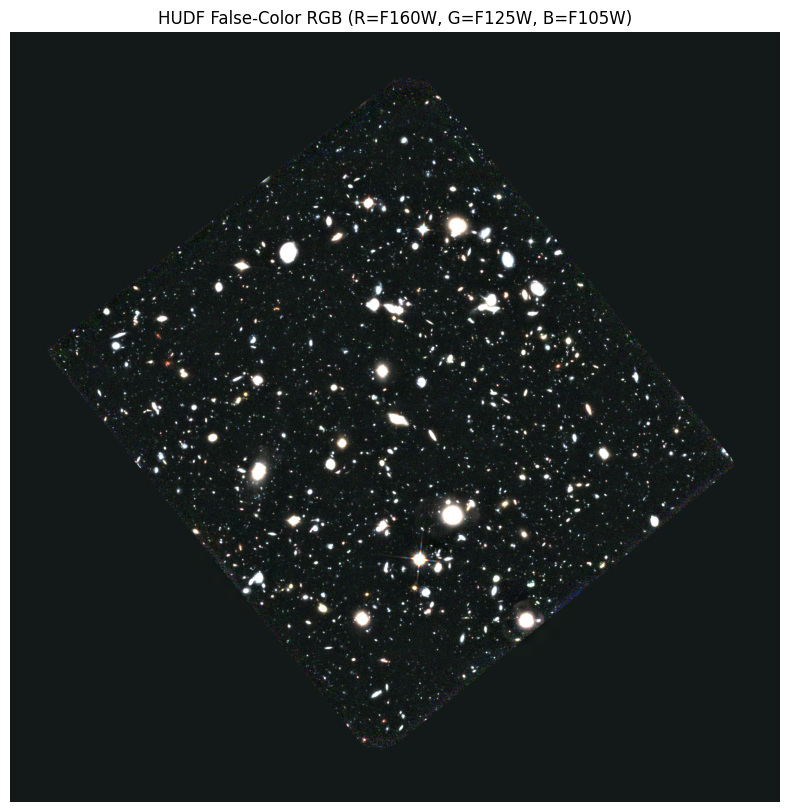

In [42]:
bkg105 = sep.Background(f105w)
bkg125 = sep.Background(f125w)
bkg160 = sep.Background(f160w)

f105w_sub = f105w - bkg105.back()
f125w_sub = f125w - bkg125.back()
f160w_sub = f160w - bkg160.back()

def scale_to_rgb(image, percentile=99):
    vmin, vmax = np.percentile(image, [1, percentile])
    image = np.clip(image, vmin, vmax)
    return (image - vmin) / (vmax - vmin)

r = scale_to_rgb(f160w_sub)  # Red = F160W
g = scale_to_rgb(f125w_sub)  # Green = F125W
b = scale_to_rgb(f105w_sub)  # Blue = F105W

rgb = np.dstack([r, g, b])

fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(rgb, origin='lower')
ax.axis('off')
ax.set_title("HUDF False-Color RGB (R=F160W, G=F125W, B=F105W)")

fig.savefig("UDF_RGB.png", bbox_inches='tight', dpi=300)
plt.show()